# Tidy Data, A Case Study Recreation
This jupyter notebook contains python code to perform the same analysis done in the case study (section 5) of Wickham's Tidy Data article. The original article and code in R can be found here: https://www.jstatsoft.org/article/view/v059i10

Created by:<br>
Andrea Gonzales<br>
Rafael Martinez<br>
Yareth Lafarga<br>
Sharon Lechuga<br>

For Machine Learning, Group 700, Dr. Miguel Gonzales Mendoza

The following notebook uses the following packages and their dependencies:<br>
-Numpy<br>
-Pandas<br>
-Plotnine<br>
-SciKit Learn<br>
-Matplotlib <br>

## Base Imports and Packages
We use two main packages to manipulate and tidy the data that we will import:
1. Numpy: Useful for array manipulation, and general math.
2. Pandas: General tools for data analysis, particularly useful to translate R functions into Python.

Further down, we use additional packages for fitting a linear model to the data we obtain. Those are imported and explained in their own section.

In [1]:
import numpy as np
import pandas as pd

## Loading data
The data used by Wickham is loaded from its CSV file here. Should any problems arise, the files can be found here: https://www.jstatsoft.org/index.php/jss/article/view/v059i10/2836

The file 'deaths08.csv.bz2' should be extracted and placed besides this file, as well as the file 'icd-main.csv'. This second file contains the codes of the diseases used later.

After loading, we print a full summary of the data. Notice that we have the 539,530 data points mentioned.

In [2]:
mortality = pd.read_csv('deaths08.csv')
codes = pd.read_csv('icd-main.csv')
codes = codes.rename(columns={'code':'cod'})
print(mortality)

         yob  mob  dob  sex age_unit  age  nation  marital  stateL  countyL  \
0       1918    0    0    1        A   90       1        2       1        1   
1       1936    0    0    1        A   72       1        2       1        1   
2       1959    0    0    1        A   49       1        5      33        0   
3       1929    0    0    2        A   79       1        5       1        1   
4       1993    0    0    1        A   15       1        1       1        1   
...      ...  ...  ...  ...      ...  ...     ...      ...     ...      ...   
539525  2008   10    5    1        D    1       1        8      32       16   
539526  2008    9   28    2        D   20       1        8      14       25   
539527  2008   11    8    2        D    3       1        8      32       17   
539528  2008    9    1    1        D   24       2        8      32       37   
539529  2008    9   20    1        D    2       1        8      32       57   

        ...  year_reg  mon_reg  day_reg  weight  ye

## Tidying: count, subset, join
In order to perform the tidying steps, we use pandas' equivalent functions.
1. To count and group by the hour of death and cause of death, we use .groupby(), specifying each column we want. We add the as_index=False to later merge it with the disease descriptions. Finally, we feed that into .size() to summarize by occurrence.
2. We drop any non-occurences using .dropna()
3. We merge hod2 and codes, two dataframes, to add the description of each disease code.
4. We eliminate 'hour 99', which is taken to mean that the time of death was not recorded, by using a filter. This is done with .query('some logic expression').

In [3]:
hod2 = mortality.groupby(['hod', 'cod'], as_index=False).size()
hod2 = hod2.dropna()
hod2 = pd.merge(hod2, codes, how='left', on='cod')
hod2 = hod2.query('hod <= 24')
print(hod2)

       hod  cod  size                                            disease
0        0  A02     1                        Other salmonella infections
1        0  A04     6              Other bacterial intestinal infections
2        0  A06     5                                          Amebiasis
3        0  A09    91  Diarrhea and gastroenteritis of infectious origin
4        0  A15     7                                                NaN
...    ...  ...   ...                                                ...
16450   24  Y09     4            Assault (homicide) by unspecified means
16451   24  Y21     1       Drowning and submersion, undetermined intent
16452   24  Y24     2  Other and unspecified firearm discharge, undet...
16453   24  Y30     1  Falling, jumping, or pushed from a high place,...
16454   24  Y34     1             Unspecified event, undetermined intent

[16455 rows x 4 columns]


## Analysis: Proportion, Frequency
In order to create the proportions and frequencies, we must find an equivalent for ddply and transform.

We can group objects using groupby to create an equivalent of ddply, and perform our transformations there. For example, we generate a dataframe temp to count the occurrence of each hour of death (mortality.groupby('hod').size() ) and we then scale it by its total, then we merge it with hod2. 

To replicate table 16, we need to do the following (reminder: Freq is used as Size in our table as that is the default name that pandas assigns it):
1. Group by hours, obtain the total amount of deaths in that hour, then obtain the proportion. For this, we need to obtain a groupby that counts the frequency of each hour, scale it, and then merge it to our original dataframe.
2. Obtain the overall proportion of the cause of deaths in total and in each hour, add it to the dataframe. We perform the same steps as above, using cod instead of hod. We used an auxiliary column, size_dis, which is computed in the case study on the next step (it is the variable 'n' in the devi dataframe), but we found useful for the generation of the prop column.


In [4]:
### 1 - Group by hours... ###
temp = mortality.groupby('hod', as_index=False).size()
temp = temp.query('hod <= 24') 
temp = temp.dropna()
temp = temp.rename(columns={'size':'size_all'})
temp['prop_all']=temp['size_all']/sum(temp['size_all'])
hod2 = pd.merge(hod2, temp, how='left', on='hod')
print(hod2)

       hod  cod  size                                            disease  \
0        0  A02     1                        Other salmonella infections   
1        0  A04     6              Other bacterial intestinal infections   
2        0  A06     5                                          Amebiasis   
3        0  A09    91  Diarrhea and gastroenteritis of infectious origin   
4        0  A15     7                                                NaN   
...    ...  ...   ...                                                ...   
16450   24  Y09     4            Assault (homicide) by unspecified means   
16451   24  Y21     1       Drowning and submersion, undetermined intent   
16452   24  Y24     2  Other and unspecified firearm discharge, undet...   
16453   24  Y30     1  Falling, jumping, or pushed from a high place,...   
16454   24  Y34     1             Unspecified event, undetermined intent   

       size_all  prop_all  
0         20517  0.038386  
1         20517  0.038386  
2  

In [5]:
### 2 - Obtain the overall proportion ###
temp = mortality.groupby('cod', as_index=False).size()
temp.dropna()
temp = temp.rename(columns={'size':'size_dis'})
hod2 = pd.merge(hod2, temp, how='left', on='cod')
hod2['prop'] = hod2['size']/hod2['size_dis']
print(hod2)

       hod  cod  size                                            disease  \
0        0  A02     1                        Other salmonella infections   
1        0  A04     6              Other bacterial intestinal infections   
2        0  A06     5                                          Amebiasis   
3        0  A09    91  Diarrhea and gastroenteritis of infectious origin   
4        0  A15     7                                                NaN   
...    ...  ...   ...                                                ...   
16450   24  Y09     4            Assault (homicide) by unspecified means   
16451   24  Y21     1       Drowning and submersion, undetermined intent   
16452   24  Y24     2  Other and unspecified firearm discharge, undet...   
16453   24  Y30     1  Falling, jumping, or pushed from a high place,...   
16454   24  Y34     1             Unspecified event, undetermined intent   

       size_all  prop_all  size_dis      prop  
0         20517  0.038386        64  0.

## Analysis: Plotting
Continuing the analysis of the data, we proceed to compare the temporal pattern of deaths, and the temporal pattern of each cause of death. 

First, we drop any diseases with less than 50 occurrences, for which we use the size_dis column and a query for only diseasses with size_dis larger than 50. This drops about 5000 rows (16455 vs 10873). We use reset_index to make all the entries sequential, accounting for the ones that were removed by this query.

Then, we compute the mean square deviation (dist), which is simple to do with numpy: np.power operate on the entire indicated columns of the dataframe without any further specification, we just create a new column with the operation. This produces the distance of each combination of hod and cod, but we must obtain the average across cod. To do this, we do a groupby operation and then average, drop the extra columns, and merge with the deviation dataframe. 

To plot, we use a scatter plot with the dataframe.plot.scatter command. We can plot a loglog plot by adding 'loglog=True' to the parameters of the command.

These commands produce the plots in figure 2 of the case study, without the linear fitting. We also show ggplot's robust linear model fitting as done in the case study.

C:\Users\fightglory\anaconda3\lib\site-packages\plotnine\stats\smoothers.py:153: PlotnineWarning: Confidence intervals are not yet implementedfor RLM smoothing.


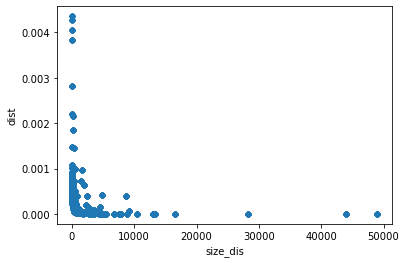

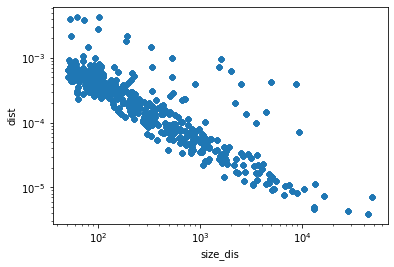

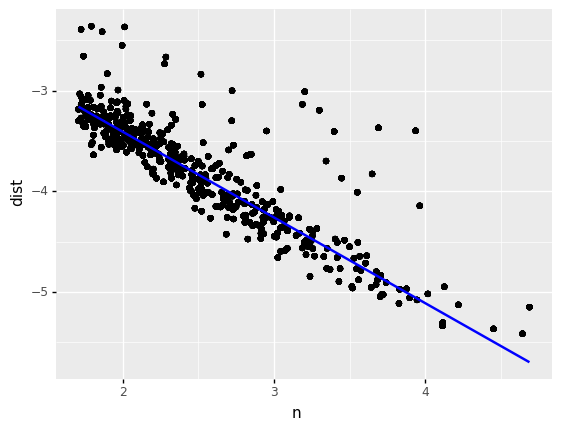

<ggplot: (178864909873)>

In [6]:

devi = hod2.query('size_dis > 50')
devi = devi.reset_index(drop=True)
devi['dist_raw'] = np.power(devi['prop']-devi['prop_all'],2)
temp = devi.groupby(['cod']).mean()
temp = temp.rename(columns={'dist_raw':'dist'})
temp = temp.drop(columns=['hod', 'size', 'size_all','prop','prop_all', 'size_dis'])
devi = pd.merge(devi, temp, how='left', on='cod')
devi = devi.drop(columns=['dist_raw'])

from plotnine import *
devi.plot.scatter(x='size_dis', y='dist')
devi.plot.scatter(x='size_dis', y='dist', loglog=True)
# Save two columns in log10 for ease of use
devi['size_10']=np.log10(devi['size_dis'])
devi['dist_10']=np.log10(devi['dist'])
(
    ggplot(devi, aes(x='size_10', y='dist_10'))
    +geom_point()
    +geom_smooth(color='blue', method='rlm')
    +labs(x='n', y='dist')
)

## Analysis: Fitting
We perform 3 different types of fit using scikit learn:
1. A Robust Linear Regression (Huber Regression)
2. A simple linear fit (Linear Regression)
3. A different form of robust linear regression (RANSAC Regression)

For the purposes of fitting, we use SciKit Learn, matplotlib for plotting, and operator for ordering the predictions.

In every regression model, the following steps take place:
1. We define the model
2. We fit the model
3. We plot the model

In [7]:
import operator
import matplotlib.pyplot as plt
from sklearn.linear_model import (
    LinearRegression,
    RANSACRegressor,
    HuberRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=1)
size_poly = polynomial_features.fit_transform(devi[['size_10']])

### Huber Regressor
The difference between a 'robust' and a 'normal' linear regression model lies in its resistance to outliers -- a particularly robust model will be less affected by points outside of the expected trend. This can be useful with noisy data, for example, or in our case where there is the presence of data points with strong temporal causation. 

The Huber Regressor's main difference lies in its loss function. Instead of the normal least squares technique (used in the next method -- a normal linear regression), Huber Regression uses a loss that is  least squares when a difference is smaller than some threshold, and uses a modified, less sensible difference otherwise:

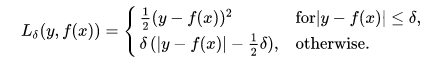

This leads to regression that will adapt less to strong outliers.

Root Mean Square Error (RMSE): 
0.2816676858585976


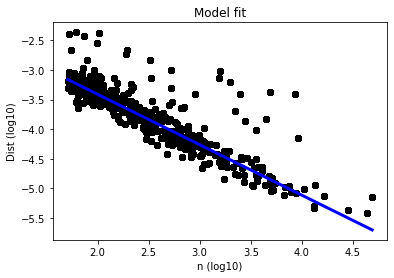

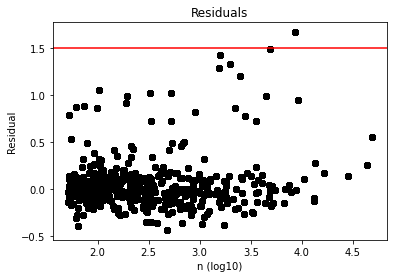

In [8]:
# Fit
model_huber=HuberRegressor()
model_huber.fit(size_poly, devi['dist_10'])
prediction_huber = model_huber.predict(size_poly)

# Plot
print("Root Mean Square Error (RMSE): ")
print(np.sqrt(mean_squared_error(devi['dist_10'],prediction_huber)))
plt.scatter(devi['size_10'],devi['dist_10'], color='black')
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(devi['size_10'],prediction_huber), key=sort_axis)
x_huber, y_huber = zip(*sorted_zip)
plt.plot(x_huber, y_huber, color='b', linewidth=3)
plt.title(label="Model fit")
plt.xlabel("n (log10)")
plt.ylabel("Dist (log10)")
plt.show()

# Residuals
plt.scatter(devi['size_10'], devi['dist_10']-prediction_huber, color='black')
plt.axhline(y=1.5, color='r')
plt.title(label="Residuals")
plt.xlabel("n (log10)")
plt.ylabel("Residual")
plt.show()

### Linear Regression
Linear Regression, in its most basic form, is the reduction of a loss function such that the predicted values of f(x) are as close as possible to the real values of f(x). It is linear as we are fitting a function that is linear in nature. All of the models discussed are, in some way, linear regression, but they differ in how we estimate the difference between the predicted and real value of f(x) (Huber Regression) or in how they determine which data points are worth fitting to (RANSAC).

Linear Regression, in its pure form, uses least squares: It computes the difference between its prediction and the observed values, for a certain linear function that serves as the prediction, squares it, and attempts to minimize that value by changing the parameters of the function.

Root Mean Square Error (RMSE): 
0.2756028139334802


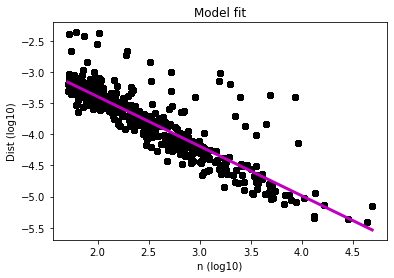

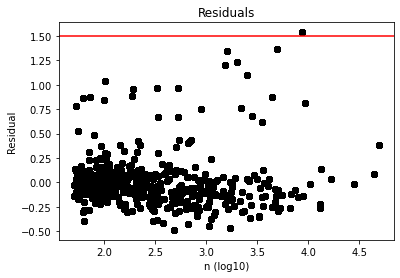

In [9]:
# Fit
model_lr=LinearRegression()
model_lr.fit(size_poly, devi['dist_10'])
prediction_lr = model_lr.predict(size_poly)

# Plot
print("Root Mean Square Error (RMSE): ")
print(np.sqrt(mean_squared_error(devi['dist_10'],prediction_lr)))
plt.scatter(devi['size_10'],devi['dist_10'], color='black')
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(devi['size_10'],prediction_lr), key=sort_axis)
x_lr, y_lr = zip(*sorted_zip)
plt.plot(x_lr, y_lr, color='m', linewidth=3)
plt.title(label="Model fit")
plt.xlabel("n (log10)")
plt.ylabel("Dist (log10)")
plt.show()

# Residuals
plt.scatter(devi['size_10'], devi['dist_10']-prediction_lr, color='black')
plt.axhline(y=1.5, color='r')
plt.title(label="Residuals")
plt.xlabel("n (log10)")
plt.ylabel("Residual")
plt.show()

### RANSAC Regressor
RANSAC, or RANdom SAmple Consensus, is a linear regression model that attempts to detect outliers so that they can be ignored for the purposes of fitting a model. The way it determines loss is with least squares, just like a normal linear regression, but it will perform this fitting multiple times while randomly selecting a set of points to fit to (these are its guess for points that are not outlier: inliers). 

The models that achieve the best fit are judged to include inliers, while the ones that do not must contain many outliers. It then decides (with a Consensus, that is, by choosing the models that performed best) which points are those that must be fitted as they have been determined to be inliers, and fits to that set of points. This can be carried out multiple times until a sufficient amount of points have been included in the consensus set.

Root Mean Square Error (RMSE): 
0.283998871235849


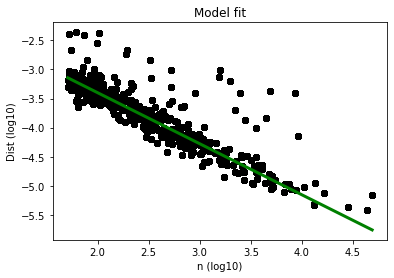

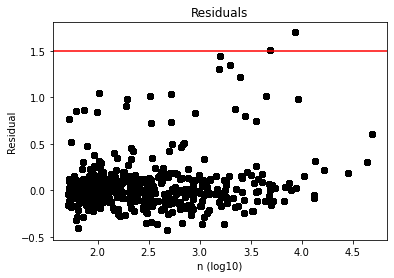

In [10]:
# Fit
model_ransac=RANSACRegressor()
model_ransac.fit(size_poly, devi['dist_10'])
prediction_ransac = model_ransac.predict(size_poly)

# Plot
print("Root Mean Square Error (RMSE): ")
print(np.sqrt(mean_squared_error(devi['dist_10'],prediction_ransac)))
plt.scatter(devi['size_10'],devi['dist_10'], color='black')
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(devi['size_10'],prediction_ransac), key=sort_axis)
x_ransac, y_ransac = zip(*sorted_zip)
plt.plot(x_ransac, y_ransac, color='g', linewidth=3)
plt.title(label="Model fit")
plt.xlabel("n (log10)")
plt.ylabel("Dist (log10)")
plt.show()

# Residuals
plt.scatter(devi['size_10'], devi['dist_10']-prediction_ransac, color='black')
plt.axhline(y=1.5, color='r')
plt.title(label="Residuals")
plt.xlabel("n (log10)")
plt.ylabel("Residual")
plt.show()

### Comparison between methods
All methods produce a linear prediction and all the predictions are very close to each other. The Linear Regression model seems to predict higher distances than the RANSAC and Huber models. This is to be expected because the outliers have higher distance -- which means that methods that do not account for outliers will tend towards estimating higher distances as well.

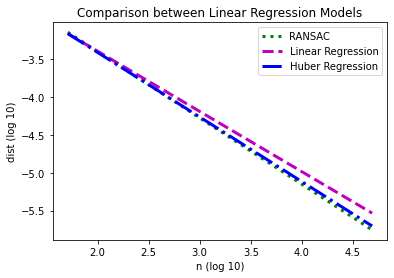

In [11]:
plt.plot(x_ransac, y_ransac, ':', color='g', linewidth=3)
plt.plot(x_lr, y_lr, '--', color='m', linewidth=3)
plt.plot(x_huber, y_huber, '-.', color='b', linewidth=3)
plt.legend(["RANSAC", "Linear Regression", "Huber Regression"])
plt.xlabel("n (log 10)")
plt.ylabel("dist (log 10)")
plt.title("Comparison between Linear Regression Models")
plt.show()

## Plotting Outliers
To finalize the recreation of the case study, we plot the same CODs as the ones the author does, although our fittings produced fewer outliers with the same decision boundary. This first block plots n>350.

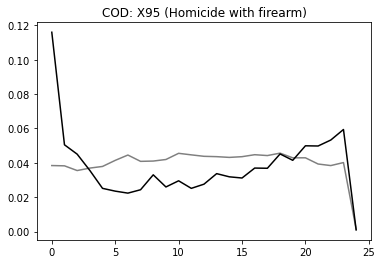

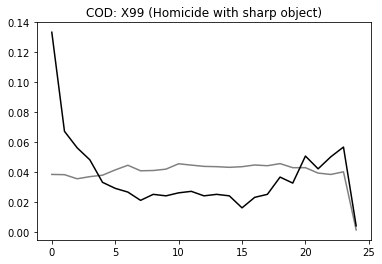

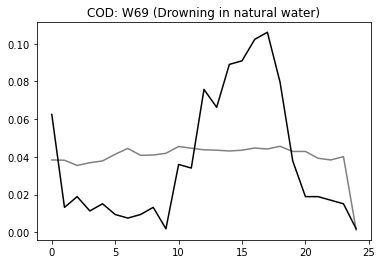

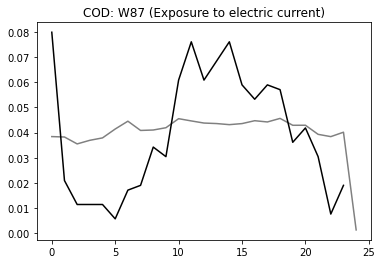

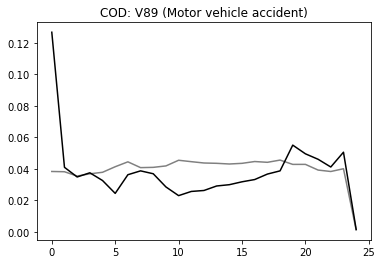

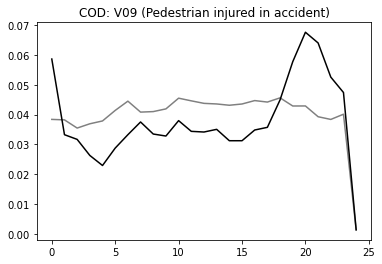

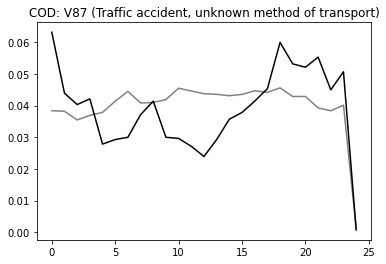

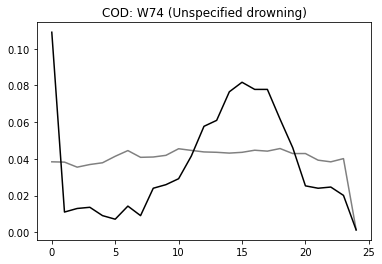

In [12]:
temp = devi.groupby(['hod'], as_index=False).mean()
x_plot = temp['hod']
y_plot = temp['prop_all']

# Extracting Assault (Homicide)
temp = devi[devi['cod'].str.contains('X95')==True]
temp = temp.reset_index(drop=True)
y_x95 = temp['prop']
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot, y_x95, color='black')
plt.title("COD: X95 (Homicide with firearm)")
plt.show()

# Extracting homicide (sharp object)
temp = devi[devi['cod'].str.contains('X99')==True]
temp = temp.reset_index(drop=True)
y_x99 = temp['prop']
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot, y_x99, color='black')
plt.title("COD: X99 (Homicide with sharp object)")
plt.show()

# Extracting Drowning in natural water
temp = devi[devi['cod'].str.contains('W69')==True]
temp = temp.reset_index(drop=True)
y_w69 = temp['prop']
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot, y_w69, color='black')
plt.title("COD: W69 (Drowning in natural water)")
plt.show()

# Extracting Exposure to electric current
temp = devi[devi['cod'].str.contains('W87')==True]
temp = temp.reset_index(drop=True)
y_w87 = temp['prop']
x_plot2 = x_plot.drop(24)
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot2, y_w87, color='black')
plt.title("COD: W87 (Exposure to electric current)")
plt.show()

# Extracting Motor accident
temp = devi[devi['cod'].str.contains('V89')==True]
temp = temp.reset_index(drop=True)
y_v89 = temp['prop']
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot, y_v89, color='black')
plt.title("COD: V89 (Motor vehicle accident)")
plt.show()

# Extracting Pedestrian injured
temp = devi[devi['cod'].str.contains('V09')==True]
temp = temp.reset_index(drop=True)
y_v09 = temp['prop']
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot, y_v09, color='black')
plt.title("COD: V09 (Pedestrian injured in accident)")
plt.show()

# Extracting Traffic accident
temp = devi[devi['cod'].str.contains('V87')==True]
temp = temp.reset_index(drop=True)
y_v87 = temp['prop']
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot, y_v87, color='black')
plt.title("COD: V87 (Traffic accident, unknown method of transport)")
plt.show()

# Extracting Unspecified submersion/drowning
temp = devi[devi['cod'].str.contains('W74')==True]
temp = temp.reset_index(drop=True)
y_w74 = temp['prop']
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot, y_w74, color='black')
plt.title("COD: W74 (Unspecified drowning)")
plt.show()

### Outliers, n<350

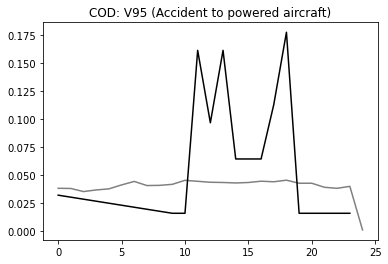

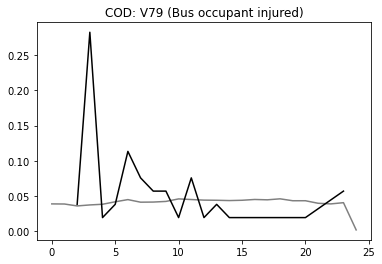

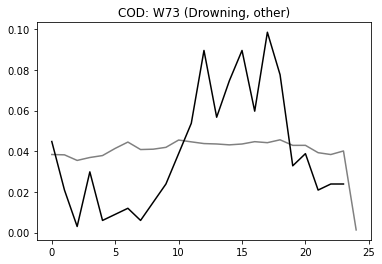

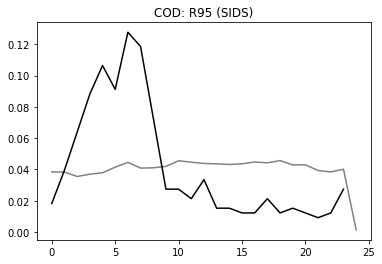

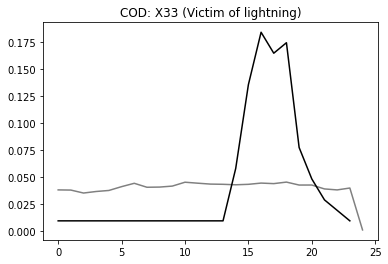

In [13]:
# Extracting Powered aircraft
temp = devi[devi['disease'].str.contains('Accident to powered aircraft causing injury to occupant')==True]
temp = temp.reset_index(drop=True)

y_v95 = temp['prop']
x_plot2 = x_plot.drop([1,2,3,4,5,6,7,8,15,20,21,24])
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot2, y_v95, color='black')
plt.title("COD: V95 (Accident to powered aircraft)")
plt.show()

# Extracting homicide (sharp object)
temp = devi[devi['disease'].str.contains('Bus occupant injured in other and unspecified transport')==True]
temp = temp.reset_index(drop=True)
y_v79 = temp['prop']
x_plot2 = x_plot.drop([0,1,18,19,21,22,24])
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot2, y_v79, color='black')
plt.title("COD: V79 (Bus occupant injured)")
plt.show()

# Extracting Drowning in natural water
temp = devi[devi['disease'].str.contains('Other specified drowning and submersion')==True]
temp = temp.reset_index(drop=True)
x_plot2 = x_plot.drop(24)
y_w73 = temp['prop']
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot2, y_w73, color='black')
plt.title("COD: W73 (Drowning, other)")
plt.show()

# Extracting SIDS
temp = devi[devi['disease'].str.contains('Sudden infant death syndrome')==True]
temp = temp.reset_index(drop=True)
y_r95 = temp['prop']
x_plot2 = x_plot.drop(24)
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot2, y_r95, color='black')
plt.title("COD: R95 (SIDS)")
plt.show()

# Extracting lightning strike
temp = devi[devi['disease'].str.contains('Victim of lightning')==True]
temp = temp.reset_index(drop=True)
x_plot2 = x_plot.drop([1,3,5,6,7,10,11,22,24])
y_x33 = temp['prop']
plt.plot(x_plot, y_plot, color='grey')
plt.plot(x_plot2, y_x33, color='black')
plt.title("COD: X33 (Victim of lightning)")
plt.show()